In [5]:
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
from catboost import CatBoostClassifier, Pool
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
@torch.no_grad()
def embed_bert_cls(model, tokenizer, texts, batch_size, device):
    all_embeds = []
    for i in tqdm(range(len(texts) // batch_size)):
        tokenzed = tokenizer(texts[batch_size*i:batch_size*i+batch_size],
                        padding = True,
                        truncation=True,
                        max_length=512,
                        return_tensors='pt')
        output = model(**{k: v.to(device) for k, v in tokenzed.items()})
        embeds = output.last_hidden_state[:, 0, :]
        all_embeds.append(embeds)
    tokenzed = tokenizer(texts[batch_size*i+batch_size:],
                        padding = True,
                        truncation=True,
                        max_length=512,
                        return_tensors='pt')
    output = model(**{k: v.to(device) for k, v in tokenzed.items()})
    embeds = output.last_hidden_state[:, 0, :]
    all_embeds.append(embeds)
    return torch.cat(all_embeds, dim=0).detach().cpu().numpy()

In [4]:
tokenizer = BertTokenizer.from_pretrained('cointegrated/LaBSE-en-ru')
base_model = BertModel.from_pretrained('cointegrated/LaBSE-en-ru', output_hidden_states=True)

/Users/aboriskin/anaconda3/envs/truth_venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.txt:   0%|          | 0.00/521k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/516M [00:00<?, ?B/s]

In [9]:
code_df_train = pd.read_excel('../data/train/merged_executed_train.xlsx')
code_df_test = pd.read_excel('../data/train/merged_executed_test.xlsx')
ood_df = pd.read_csv('../data/jailbreaks/ood_travel.csv', delimiter=';')
print_df = pd.read_csv('../data/jailbreaks/ood_print_samples.csv')
df = pd.concat([code_df_train, code_df_test])['student_solution'].to_frame()
df['label'] = 0
df = df.rename(columns={'student_solution': 'text'})
df = pd.concat([df, ood_df[ood_df['label']==1]])
df = pd.concat([df, print_df])
df.shape

(1636, 2)

In [12]:
embeddings = embed_bert_cls(
    model=base_model, 
    tokenizer=tokenizer,
    texts=df['text'].to_list(), 
    batch_size=32,
    device='cpu'
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:21<00:00,  2.43it/s]


In [13]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, np.array(df['label'].to_list()), test_size=0.2, random_state=42)

In [14]:
clf = CatBoostClassifier(
    iterations=10,
)

clf.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
)

Learning rate set to 0.251022
0:	learn: 0.2548065	test: 0.2622504	best: 0.2622504 (0)	total: 105ms	remaining: 948ms
1:	learn: 0.0984563	test: 0.1042448	best: 0.1042448 (1)	total: 132ms	remaining: 529ms
2:	learn: 0.0512430	test: 0.0563318	best: 0.0563318 (2)	total: 155ms	remaining: 361ms
3:	learn: 0.0318632	test: 0.0364885	best: 0.0364885 (3)	total: 175ms	remaining: 263ms
4:	learn: 0.0201759	test: 0.0226182	best: 0.0226182 (4)	total: 196ms	remaining: 196ms
5:	learn: 0.0138625	test: 0.0162818	best: 0.0162818 (5)	total: 219ms	remaining: 146ms
6:	learn: 0.0094637	test: 0.0113965	best: 0.0113965 (6)	total: 241ms	remaining: 103ms
7:	learn: 0.0073121	test: 0.0088874	best: 0.0088874 (7)	total: 263ms	remaining: 65.7ms
8:	learn: 0.0057450	test: 0.0070682	best: 0.0070682 (8)	total: 284ms	remaining: 31.5ms
9:	learn: 0.0046321	test: 0.0058295	best: 0.0058295 (9)	total: 304ms	remaining: 0us

bestTest = 0.005829536701
bestIteration = 9



In [15]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(f'roc_auc_score: {roc_auc_score(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       1.00      1.00      1.00       255

    accuracy                           1.00       328
   macro avg       1.00      1.00      1.00       328
weighted avg       1.00      1.00      1.00       328

roc_auc_score: 1.0


In [16]:
clf.eval_metrics(Pool(X_test, label=y_test),
                             metrics=['F1'],
                             plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'F1': [0.9921259842519685, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}

In [ ]:
clf.save_model('catboost_ood',
           format="cbm",
           export_parameters=None,
           pool=None)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:20<00:00,  2.51it/s]


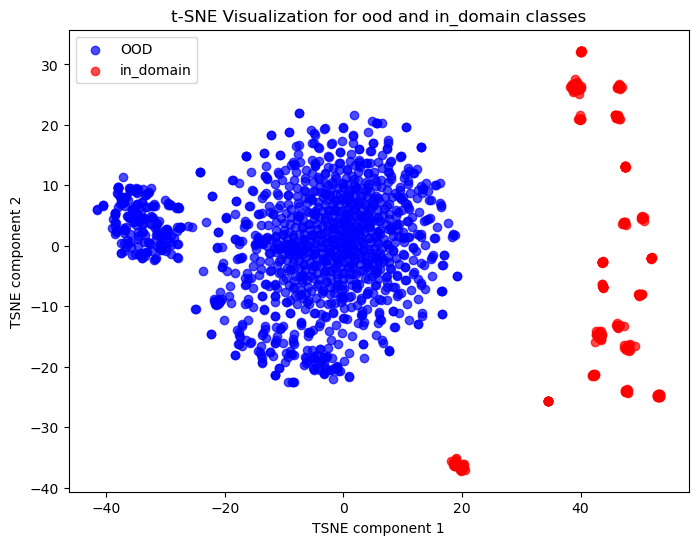

In [17]:
class_1_data = df[df['label'] == 1].drop('label', axis=1)
class_0_data = df[df['label'] == 0].drop('label', axis=1)

combined_data = pd.concat([class_1_data, class_0_data])

combined_data  = embed_bert_cls(
    model=base_model, 
    tokenizer=tokenizer,
    texts=combined_data['text'].to_list(), 
    batch_size=32,
    device='cpu'
)

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(combined_data)

combined_labels = pd.concat([df[df['label'] == 1]['label'], df[df['label'] == 0]['label']])

plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[combined_labels == 1, 0], tsne_results[combined_labels == 1, 1], 
            label='OOD', color='blue', alpha=0.7)
plt.scatter(tsne_results[combined_labels == 0, 0], tsne_results[combined_labels == 0, 1], 
            label='in_domain', color='red', alpha=0.7)

plt.title('t-SNE Visualization for ood and in_domain classes')
plt.xlabel('TSNE component 1')
plt.ylabel('TSNE component 2')
plt.legend()
plt.show()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.52it/s]


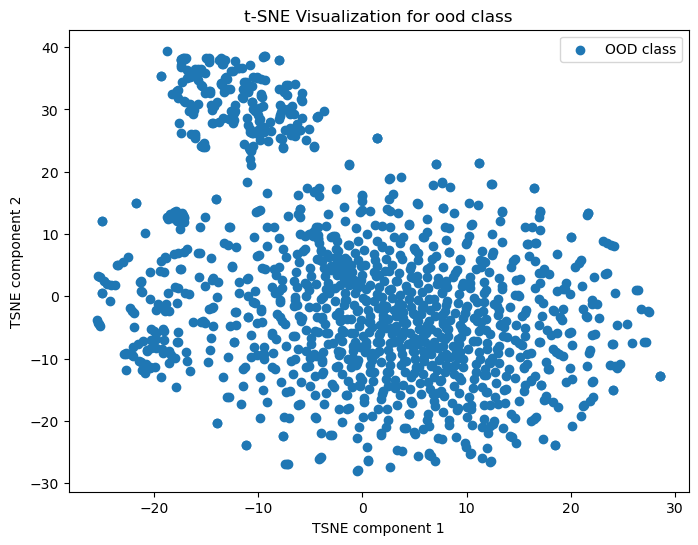

In [18]:
class_1_data = df[df['label'] == 1].drop('label', axis=1)

class_1_data = embed_bert_cls(
    model=base_model, 
    tokenizer=tokenizer,
    texts=class_1_data['text'].to_list(), 
    batch_size=32,
    device='cpu'
)

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(class_1_data)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], label='OOD class')
plt.title('t-SNE Visualization for ood class')
plt.xlabel('TSNE component 1')
plt.ylabel('TSNE component 2')
plt.legend()
plt.show()
